In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import sympy as sp 
from sympy import *
import random
from scipy.linalg import expm
from sympy.physics.quantum import TensorProduct
import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
sp.init_printing()

In [2]:
#nomenculture like E01 ground energy of qubit 1 
E11,E01,P1, E_11, E_01, J11 = sp.symbols("E_{11} E_{01} P_{1} E_{11c} E_{01c} J_{11}")
I2 = sp.eye(2)
a_dag = sp.Matrix([[0,0],
                   [1,0]])
sigmap = sp.Matrix([[0,0],[1,0]])
sigmam=sigmap.T
#state of our reservior system 
qr1 = sp.Matrix([[E01,P1.conjugate()],
                 [P1,E11]])
#hamil of res, if more tensor of all
qrh = qr1
c1 = sp.Matrix([[E_01,0],[0,E_11]])
#hamilt of comp sys
ch = c1
#hamil of total system is thus
Hh = TensorProduct(ch,I2) + TensorProduct(I2,qrh)
#can edit values here if need be
E01,E_11c, E_01c = (0,0,0)

ch = ch.subs({"E_{11c}":E_11c, "E_{01c}":E_01c})
qrh = qrh.subs({"E_{11}":E11,"E_{01}":E01,"P_{1}":P1})
#just rewritting hamil with zero potential+gnd state
H = TensorProduct(ch,I2) + TensorProduct(I2,qrh)
#now to introduce coupling 
def MTP(A,B):
    return TensorProduct(A,B)
H = H + J11.conjugate()*(MTP(sigmap,a_dag.T)) + J11 * (MTP(sigmam, a_dag))


In [3]:
#basis vector representation & defining initial computational and reservoir qubits
#assuming QN in vacuum state

gnd_state = np.array([[1],[0]]) #the |0> state

phi_initial_g = np.array([[1],[0]]) #the |0> state for computational qubit
vac = np.array([[1],[0]]) #the |0> state for reservoir qubit
phi_initial_e = np.array([[0],[1]]) #the |1> state for computational qubit

exc_state = np.array([[0],[1]]) #the |1> state

In [11]:
Hcopy = H
E0 = 1 #variance of uniform distrib of energies E0
P11_array = np.linspace(1, 100, 4) / E0 #defining length of this array as my boundary for rest of code
J_array = np.linspace(1, 100, 4) / E0
E11_array = np.zeros(len(P11_array)) #choosing series of V based on distribution
for i in range(len(P11_array)):
    E11 = float(-E0/2 +(np.random.rand(1)*E0)) #onsite V for reservoir qubits
    E11_array[i] =  E11 #check decimals => possible errors?

#a dictionary, for e.g: H_dic[1] contains H matrix which contain values of P11_array[1] 
#and J_array[1] and E11_array[1] in matrix
H_dic={} 
for i in range(len(P11_array)):
    H_dic[i] = np.array(Hcopy.subs({"E_{11}":E11_array[i],"P_{1}":P11_array[i],
        "J_{11}":J_array[i]})).astype('complex128') * 1/E0
hbar = 1
t = 3 * E0/hbar #simulation time -> scaled time

#For e.g: U_dic[2] going to contain U matrix 
#calculated with H[2] matrix (contains P11[2] and J[2] and E11[2] values)
U_dic = {}
for i in range(len(P11_array)):
    U_dic[i] = expm(-1j* H_dic[i] * t)
    
##########################################################################################

x1_array = np.zeros(len(P11_array))
y1_array = np.zeros(len(P11_array))
x2_array = np.zeros(len(P11_array))
y2_array = np.zeros(len(P11_array))
z1_array = np.zeros(len(P11_array),dtype=np.complex128)
z2_array = np.zeros(len(P11_array),dtype=np.complex128)
phi_initial={} #going to contain some sample of intial states of our COMPUTATIONAL site
for i in range(len(P11_array)):
    x1_array[i] = float(-E0/2 +(np.random.rand(1)*E0)) # number b/w -E0/2 and E0/2
    y1_array[i] = float(-E0/2 +(np.random.rand(1)*E0))
    x2_array[i] = float(-E0/2 +(np.random.rand(1)*E0))
    y2_array[i] = float(-E0/2 +(np.random.rand(1)*E0))
    z1_array[i] = complex(x1_array[i],y1_array[i])
    z2_array[i] = complex(x2_array[i],y2_array[i])
    # 1/N * [ (a|0>+b|1>) (x) |0> ]
    phi_initial[i]=(z1_array[i]*phi_initial_g + z2_array[i]*phi_initial_e) #defining
    #series of phi_in state for each complex 
    
##########################################################################################

#the |phi_initial> (x)  |vac>_QN state = |psi_initial>, my initial states
#psi_initial[0],psi_initial[1],psi_initial[2],psi_initial[3] in this case
psi_initial={} 
for i in range(len(P11_array)):#sqrt below is the norm factor
    psi_initial[i] = 1/np.sqrt(np.abs(z1_array[i])**2+np.abs(z2_array[i])**2)*(
        MTP(phi_initial[i], vac) ) #where vac = (0,1)

##########################################################################################

#size 16 values in this case, psi_out[1] = U[1]*psi_intial[0]
#psi_out[3] is U[3]*psi_intial[0], psi_out[4] is U[0]*psi_intial[1],psi_out[5] 
#is U[1]*psi_intial[1] ## basically U0/U1/U2/U3 on psi0 (first 4 array elements in psi_out) 
#then on psi1 and so on

psi_out = [] 
for i in range(len(psi_initial)):
    for j in range(len(P11_array)):
        psi_out.append(U_dic[j]@psi_initial[i])
        
#so if i want to see the evolution of initial state 0 with say P[2] J[2] E[2] values
#i would output/call psi_out[2] (=U[2]*psi_initial[0])
#or if i want to see evolution of state 3 with E1,P1,J1 values
#psi_out[13] (=U[1]psi_initial[3])
##########################################################################################

#pho_d[3] contains density matrix of |psi_out[3]><psi_out[3]|, about psi_initial[0]
pho_d = {} 
for i in range(len(psi_out)):
    pho_d[i] = MTP(psi_out[i],psi_out[i].conjugate().T)
########################## egienvalue test ############################################
# k = pho_d[0]
# for i in range(len(pho_d[0])):
#     for j in range(len(pho_d[0])):
#         if i==j:
#             print(k[i][j])
########################## egienvalue test ############################################

##########################################################################################

#we have 16 psi_out elements(=array), the first 4 values represent the psi_initial[0] evolution
#with different U
#so pho_c is going to contain a reduced matrix for each of the computational qubit in the 16
#psi_out elements (elements=array)
#so pho_c[0] to pho_c[3] represents the reduced matrix for psi_out[0] to psi_out[3]
#pho_c[4] to pho_c[7] represents the reduced matrix for psi_out[4] to psi_out[7] and so on
pho_c = {}
Id = np.eye(2) 
for i in range(len(pho_d)):
    pho_c[i] = MTP(Id, gnd_state.T)@pho_d[i]@MTP(Id, gnd_state) +( 
    MTP(Id, exc_state.T)@pho_d[i]@MTP(Id, exc_state) )

##########################################################################################

#defining the ideal states, with the series sample of phi_intial
#essentially the z1 and z2 complex values swapped over with X_gate
X_gate = np.array([[0,1],[1,0]])
phi_ideal = {}
for i in range(len(phi_initial)): 
    phi_ideal[i] = X_gate @ phi_initial[i]

##########################################################################################

#defining the fidelity F = <phi_ideal|pho_c|phi_ideal>
#F[0] to F[3] represents the Fidelity for pho_c[0] to pho_c[3]
#which represents the reduced matrix for psi_out[0] to psi_out[3]
#where psi_out[0] to psi_out[3] is U[0]*psi_intial[0] to U[3]*psi_intial[0]
F = {}
k=0
for i in range(len(pho_c)):
    for j in range(len(phi_ideal)):
        if k == len(pho_c):
            break;
        F[k] = phi_ideal[j].conjugate().T @ pho_c[k] @ phi_ideal[j]
        k+=1

# F_array = np.zeros((len(P11_array), len(J_array)))
# for i in range(len(P11_array)):
#     for j in range(len(J_array)):
#         F_array[i,j] = F[i][0][0]
# #print('\n'P)
# # fig, axs = plt.subplots(2,2)
# # axs[0,0].plot(F_array, P11_array, 'b', label = 'comparison with P values')
# # axs[0,0].legend()
# # #axs[0,0].set_title('prob distribution of state |00>')
# # axs[0,1].plot(F_array, J_array, 'g', label = 'comparison with J values')
# # axs[0,1].legend()
# # axs[1,0].plot(F_array**2, P11_array, 'b', label = 'P comparison with squared F')
# # axs[1,0].legend()
# # axs[1,1].plot(F_array**2, J_array, 'g', label = 'J comparison with squared F')
# # axs[1,1].legend()
# # for ax in axs.flat:
# #     ax.set(xlabel='F(Top row) F^2(bottowm row)', ylabel='P(blue)&J(green)')

# # # Hide x labels and tick labels for top plots and y ticks for right plots.
# # for ax in axs.flat:
# #     ax.label_outer()
# def forceAspect(ax,aspect=1):
#     im = ax.get_images()
#     extent =  im[0].get_extent()
#     ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

# fig, ax = plt.subplots()
# #ax.set_aspect('auto')
# #plt.imshow(Z.T, cmap='bwr', interpolation='bicubic')
# pos = ax.imshow(F_array, cmap='bwr', interpolation='bicubic')
# ax.invert_yaxis()
# forceAspect(ax,aspect=1)
# cbar = plt.colorbar(pos)
# ax.set_xlabel('P values')
# ax.set_ylabel('J values')
# cbar.set_label(r'F')
# plt.show()
# print('Variance E0 =',E0,'\nJ =', J_array, '\nP =', P11_array, '\nE1 =', E11)



In [ ]:
#some testing below of outputs
## junk code start ##

In [46]:
psi_out[0],psi_out[1],psi_out[2][3][0],psi_out[2],np.abs(psi_out[3])**2

(array([[ 0.05875031-0.16968744j],
        [ 0.59290439-0.28904582j],
        [-0.13194845+0.04676598j],
        [-0.33214811-0.63462718j]]),
 array([[ 0.00669912+0.61267141j],
        [ 0.08781205+0.57356471j],
        [ 0.08009769-0.3821226j ],
        [-0.1263729 +0.34568483j]]),
 (0.6974515734979585-0.0013692181244633894j),
 array([[-0.06366587+0.06040421j],
        [-0.07545224-0.70440998j],
        [-0.01012973-0.06219606j],
        [ 0.69745157-0.00136922j]]),
 array([[0.39561034],
        [0.3268075 ],
        [0.14953009],
        [0.12805206]]))

In [83]:
F[0],F[1],F[2],F[3]

(array([[0.15083016+1.38777878e-17j]]),
 array([[0.37282293+2.77555756e-17j]]),
 array([[0.28039752+0.j]]),
 array([[0.15614931-6.9388939e-18j]]))

In [149]:
F

{0: array([[0.2222523-1.38777878e-17j]]),
 1: array([[0.00952933+0.j]]),
 2: array([[0.0760541-6.9388939e-18j]]),
 3: array([[0.0787497-8.67361738e-19j]]),
 4: array([[0.01284617-1.73472348e-18j]]),
 5: array([[0.05407223-1.73472348e-18j]]),
 6: array([[0.11832382-3.46944695e-18j]]),
 7: array([[0.05703677+0.j]]),
 8: array([[0.20096505+0.j]]),
 9: array([[0.02363644-4.33680869e-19j]]),
 10: array([[0.01878306+0.j]]),
 11: array([[0.07236342+1.73472348e-18j]]),
 12: array([[0.21568634+6.9388939e-18j]]),
 13: array([[0.01531144+0.j]]),
 14: array([[0.04444753+0.j]]),
 15: array([[0.07595229+0.j]])}

In [ ]:
## junk code finished ##

In [18]:
#lets look at U[0] (P[0],J0 and E0 values) application to each intial state
#that is U[0]psi_initial[0], U[0]psi_initial[1], U[0]psi_initial[2] & U[0]psi_initial[3]
# i.e psi_out[0], psi_out[4], psi_out[8] & psi_out[12] => pho_c[0],...,pho_c[12]
# which the corresponding Fidellity F[0], F[4]...F[12]
for i in range(len(psi_out)):
    if i%4==0:
        print(f"\npsi_out{i} = U[0]psi_initial{i/4}","\n\n",psi_out[i], '\t', f'F{i}', F[i])
    


psi_out0 = U[0]psi_initial0.0 

 [[ 0.08746717+0.07463647j]
 [-0.65473032+0.22643005j]
 [-0.16785129+0.18476964j]
 [-0.66275302-0.07267116j]] 	 F0 [[0.37669238+0.j]]

psi_out4 = U[0]psi_initial1.0 

 [[-0.23290264-0.02302276j]
 [ 0.27461302-0.63443826j]
 [ 0.10070784-0.21279779j]
 [ 0.63141572-0.11485347j]] 	 F4 [[0.3474576+0.j]]

psi_out8 = U[0]psi_initial2.0 

 [[ 0.41971643+0.06446295j]
 [ 0.34007335+0.34902046j]
 [-0.24617017-0.08532554j]
 [-0.2475775 -0.67308444j]] 	 F8 [[0.01822864-3.03576608e-18j]]

psi_out12 = U[0]psi_initial3.0 

 [[ 0.06784847-0.41646937j]
 [ 0.73940704-0.40781442j]
 [-0.02225126+0.10338258j]
 [-0.27151959+0.15494682j]] 	 F12 [[0.08631236-6.9388939e-18j]]


In [72]:
%matplotlib inline

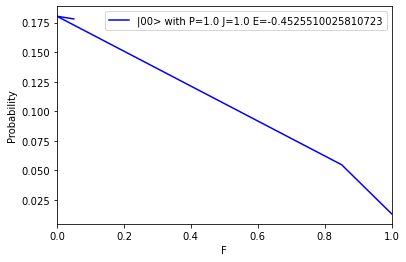

In [13]:
#store complex coefficient |00> state
a_array = np.zeros(len(P11_array))
#store complex coefficient |01> state
b_array = np.zeros(len(P11_array))
#store complex coefficient |10> state
c_array = np.zeros(len(P11_array))
#store complex coefficient |11> state
d_array = np.zeros(len(P11_array))
#Fidelity 
F_array = np.zeros(len(P11_array))
j=0
for i in range(len(psi_out)):
    if i%4==0:
        a_array[j] = np.abs(psi_out[i][0][0])**2
        b_array[j] = np.abs(psi_out[i][1][0])**2
        c_array[j] = np.abs(psi_out[i][2][0])**2
        d_array[j] = np.abs(psi_out[i][3][0])**2
        F_array[j] = np.abs(F[i][0][0])**2
        j+=1
norm_F_array = (F_array - np.min(F_array)) / (np.max(F_array) - np.min(F_array))
plt.plot(norm_F_array, a_array, 'b', label=f'|00> with P={P11_array[0]} J={J_array[0]} E={E11_array[0]}')
plt.xlim([0, 1])
plt.xlabel('F')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [142]:
#F_array, F[0][0][0], 
a_array

array([0.00451086, 0.01504411, 0.06126021, 0.03273615])

In [158]:
F_array

array([0.04939609, 0.00016502, 0.04038695, 0.0465206 ])

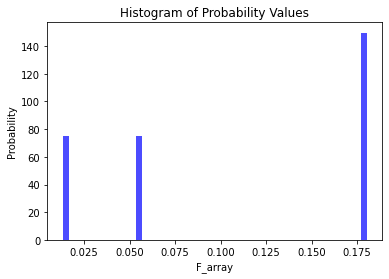

In [14]:
num_bins =50
n, bins, patches = plt.hist(a_array, num_bins, density=True, histtype='bar', color='blue', alpha=0.7)
plt.xlabel('F_array')
plt.ylabel('Probability')
plt.title('Histogram of Probability Values')
#plt.xlim([0,1])
plt.show()

(array([220.26684806,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 220.26684806,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
        220.26684806,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 220.26684806]),
 array([0.00451086, 0.00564585, 0.00678084, 0.00791582, 0.00905081,
        0.0101858 , 0.01132078, 0.01245577, 0.01359076, 0.01472574,
        0.01586073, 0.01699572, 0.0181307 , 0.01926569, 0.

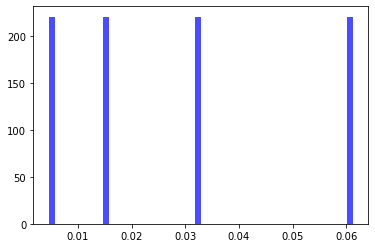

In [126]:
plt.hist(a_array, num_bins, density=True, histtype='bar', color='blue', alpha=0.7)

In [71]:
import matplotlib.rcsetup as rcsetup
print(rcsetup.all_backends)

['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


In [70]:
np.abs(a_array)**2,np.abs(F_array)**2

(array([0.05890351, 0.05890351, 0.05890351, 0.05890351]),
 array([0.04717524, 0.04717524, 0.04717524, 0.04717524]))

In [373]:
len(pho_c),len(phi_ideal), len(pho_d), len(psi_final), len(psi_initial)

In [376]:
#pho_d[0],len(F), pho_c[0]
#psi_out[4], pho_c[4]
F[0][0][0]

(0.45094717026645786+1.3877787807814457e-17j)

In [68]:
np.abs(F[0][0][0])**2

D:\User\Rojar\Documents\Anaconda\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDep

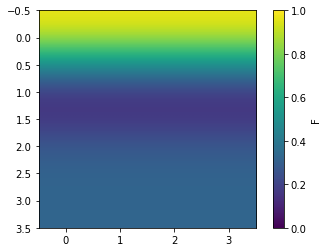

In [175]:
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
fig, ax = plt.subplots()
X,Y = np.meshgrid(P11_array,J_array)
#ax.set_aspect('auto')
F_array = np.zeros((len(P11_array), len(J_array)))
for i in range(len(P11_array)):
    for j in range(len(J_array)):
        F_array[i,j] = np.abs(F[i][0][0])
norm_F_array = (F_array - np.min(F_array)) / (np.max(F_array) - np.min(F_array))
pos=ax.imshow(norm_F_array, cmap='viridis', interpolation='bicubic')
forceAspect(ax,aspect=1)
cbar = plt.colorbar(pos)
cbar.set_label(r'F')
plt.show()


In [162]:
X, Y

(array([[  1.,  34.,  67., 100.],
        [  1.,  34.,  67., 100.],
        [  1.,  34.,  67., 100.],
        [  1.,  34.,  67., 100.]]),
 array([[  1.,   1.,   1.,   1.],
        [ 34.,  34.,  34.,  34.],
        [ 67.,  67.,  67.,  67.],
        [100., 100., 100., 100.]]))

In [168]:
o = np.meshgrid([1,2,3], [5,6,7], sparse = False)
o

[array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]),
 array([[5, 5, 5],
        [6, 6, 6],
        [7, 7, 7]])]

In [144]:
P11_array, J_array

(array([  1.,  34.,  67., 100.]), array([  1.,  34.,  67., 100.]))

In [145]:
F_array

array([[0.15083016, 0.15083016, 0.15083016, 0.15083016],
       [0.37282293, 0.37282293, 0.37282293, 0.37282293],
       [0.28039752, 0.28039752, 0.28039752, 0.28039752],
       [0.15614931, 0.15614931, 0.15614931, 0.15614931]])

In [138]:
norm_F_array

array([[0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [0.58365578, 0.58365578, 0.58365578, 0.58365578],
       [0.02396092, 0.02396092, 0.02396092, 0.02396092]])

In [216]:
psi_initial[3]

array([[-0.69195217+0.59150462j],
       [ 0.        +0.j        ],
       [ 0.34141529+0.2340087j ],
       [ 0.        +0.j        ]])

In [168]:
U_dic[3]@psi_initial[2]

array([[ 0.07435848+0.14102152j],
       [-0.20912728+0.80718712j],
       [-0.00667975-0.07860197j],
       [-0.14020304+0.50340709j]])

In [175]:
# for i in range(len(P11_array)):
#     psi_final[i] = U_dic[i]@psi_initial[i] #where t = 3 units
##########################################################################################
psi_final = []
for i in range(len(P11_array)):
    for j in range(len(P11_array)):
        psi_final.append(U_dic[j]@psi_initial[i])
len(psi_final)

In [159]:
U_dic[0]@psi_initial[0], psi_final[0]

(array([[ 0.40760901+0.09934657j],
        [ 0.22921793+0.38873054j],
        [-0.25086428-0.07829775j],
        [-0.27167105-0.69098789j]]),
 array([[ 0.77279985-0.34832156j],
        [-0.05774145+0.00135664j],
        [-0.47632561+0.21749552j],
        [-0.00796652+0.06215078j]]))

In [42]:
F_array

array([[0.22610683, 0.22610683, 0.22610683, 0.22610683],
       [0.35961828, 0.35961828, 0.35961828, 0.35961828],
       [0.72760437, 0.72760437, 0.72760437, 0.72760437],
       [0.72760437, 0.72760437, 0.72760437, 0.72760437]])

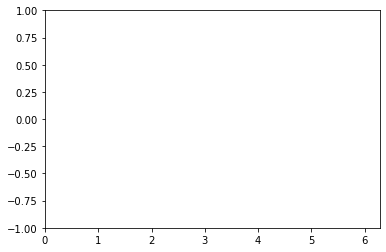

In [82]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = F_array, J_array
ln, = ax.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

# lets look at evolution of basis states with single value

In [176]:
H

D:\User\Rojar\Documents\Anaconda\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDep

⎡       _____                 ⎤
⎢  0    P_{1}     0       0   ⎥
⎢                             ⎥
⎢P_{1}  E_{11}  J_{11}    0   ⎥
⎢                             ⎥
⎢       ______          _____ ⎥
⎢  0    J_{11}    0     P_{1} ⎥
⎢                             ⎥
⎣  0      0     P_{1}   E_{11}⎦

In [179]:
H_dic

{0: array([[0.        +0.j, 1.        +0.j, 0.        +0.j, 0.        +0.j],
        [1.        +0.j, 0.42978753+0.j, 1.        +0.j, 0.        +0.j],
        [0.        +0.j, 1.        +0.j, 0.        +0.j, 1.        +0.j],
        [0.        +0.j, 0.        +0.j, 1.        +0.j, 0.42978753+0.j]]),
 1: array([[ 0.        +0.j, 34.        +0.j,  0.        +0.j,
          0.        +0.j],
        [34.        +0.j, -0.33033027+0.j, 34.        +0.j,
          0.        +0.j],
        [ 0.        +0.j, 34.        +0.j,  0.        +0.j,
         34.        +0.j],
        [ 0.        +0.j,  0.        +0.j, 34.        +0.j,
         -0.33033027+0.j]]),
 2: array([[ 0.        +0.j, 67.        +0.j,  0.        +0.j,
          0.        +0.j],
        [67.        +0.j, -0.19477714+0.j, 67.        +0.j,
          0.        +0.j],
        [ 0.        +0.j, 67.        +0.j,  0.        +0.j,
         67.        +0.j],
        [ 0.        +0.j,  0.        +0.j, 67.        +0.j,
         -0.19477714+0

D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


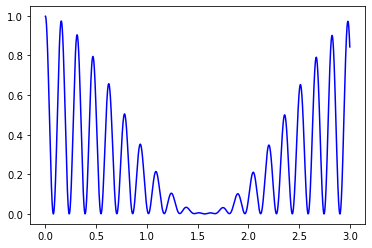

In [288]:
len(U), len(psi_initial), U, psi_initial

(2,
 2,
 {0: array([[ 9.99800007e-01+2.14134142e-08j, -3.21192560e-06-1.99986530e-02j,
          -1.99986599e-05+2.14125576e-09j,  2.14134184e-11+1.33327971e-07j],
         [-3.21192560e-06-1.99986530e-02j,  9.99797955e-01-3.21170930e-04j,
          -3.21171147e-07-1.99973197e-03j, -1.99986595e-05+4.28259758e-09j],
         [-1.99986599e-05+2.14125576e-09j, -3.21171147e-07-1.99973197e-03j,
           9.99798007e-01+2.16275397e-08j, -3.21192560e-06-1.99986530e-02j],
         [ 2.14134184e-11+1.33327971e-07j, -1.99986595e-05+4.28259758e-09j,
          -3.21192560e-06-1.99986530e-02j,  9.99799955e-01-3.21171358e-04j]]),
  1: array([[ 9.99800007e-01+4.77050996e-10j, -7.15557221e-08-1.99986534e-02j,
          -1.99986600e-05+4.77031914e-11j,  4.77051091e-13+1.33327973e-07j],
         [-7.15557221e-08-1.99986534e-02j,  9.99798007e-01-7.15509039e-06j,
          -7.15509516e-09-1.99973201e-03j, -1.99986600e-05+9.54083005e-11j],
         [-1.99986600e-05+4.77031914e-11j, -7.15509516e-09-1.99973

In [289]:
a_array

array([-0.10474513-0.66831605j, -0.10471407-0.66819312j,
       -0.10462088-0.6678244j , ..., -0.38079832-0.47133498j,
       -0.37848413-0.46593034j, -0.37600852-0.46036528j])

D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



P =  20.0 	J =  2.0 	E =  -0.4530197090231768 
Initial State =  [[-0.35267378-0.34632541j]
 [-0.03740667+0.16405483j]
 [ 0.05103048-0.79672584j]
 [-0.28572691-0.09138174j]]


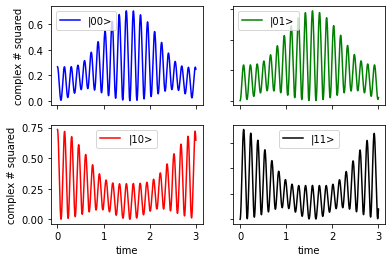

In [19]:
Hcopy = H
E0 = 1 #variance of uniform distrib of energies E0
P = 20 / E0
J = 2 / E0
n = 2 #how many E values from distribution
E_array = np.zeros(n)
for i in range(n):
    E = float(-E0/2 +(np.random.rand(1)*E0)) #onsite V for reservoir qubits
    E_array[i] =  E #check decimals => possible errors?

Hamil = {}
for i in range(n):
    Hamil[i] = np.array(Hcopy.subs({"E_{11}":E_array[i],"P_{1}":P,
        "J_{11}":J})).astype('complex128') * 1/E0
hbar = 1
dt = 0.001 * E0/hbar
nsteps = 3000 # think like total time your simulation run for
T = nsteps  * dt #total time
t = np.arange(0, T+dt, dt) #creates array from 0 to T +dt in steps of dt
U = {}
for i in range(n):
    U[i] = expm(-1j* Hamil[i] * dt)

    
x1_array = np.zeros(n)
y1_array = np.zeros(n)
x2_array = np.zeros(n)
y2_array = np.zeros(n)
z1_array = np.zeros(n, dtype=np.complex128)
z2_array = np.zeros(n, dtype=np.complex128)
phi_initial={} #going to contain some sample of intial states of our COMPUTATIONAL site
for i in range(n):
    x1_array[i] = float(-E0/2 +(np.random.rand(1)*E0)) # number b/w -E0/2 and E0/2
    y1_array[i] = float(-E0/2 +(np.random.rand(1)*E0))
    x2_array[i] = float(-E0/2 +(np.random.rand(1)*E0))
    y2_array[i] = float(-E0/2 +(np.random.rand(1)*E0))
    z1_array[i] = complex(x1_array[i],y1_array[i])
    z2_array[i] = complex(x2_array[i],y2_array[i])
    # 1/N * [ (a|0>+b|1>) (x) |0> ]
    phi_initial[i]=(z1_array[i]*phi_initial_g + z2_array[i]*phi_initial_e) #defining
    #series of phi_in state for each complex 
    
#the |phi_initial> (x)  |vac>_QN state = |psi_initial>
psi_initial={} 
for i in range(n):#sqrt below is the norm factor
    psi_initial[i] = 1/np.sqrt(np.abs(z1_array[i])**2+np.abs(z2_array[i])**2)*(
        MTP(phi_initial[i], vac) ) #where vac = (0,1)

# defining complex coefficients and real/imag variables for evolved state
a_array = np.zeros(len(psi_initial)*len(t),dtype=np.complex128)
b_array = np.zeros(len(psi_initial)*len(t),dtype=np.complex128)
c_array = np.zeros(len(psi_initial)*len(t),dtype=np.complex128)
d_array = np.zeros(len(psi_initial)*len(t),dtype=np.complex128)
a_complex_real = np.zeros(len(psi_initial)*len(t))
a_complex_imag = np.zeros(len(psi_initial)*len(t),dtype=np.complex128)
b_complex_real = np.zeros(len(psi_initial)*len(t))
b_complex_imag = np.zeros(len(psi_initial)*len(t),dtype=np.complex128)
c_complex_real = np.zeros(len(psi_initial)*len(t))
c_complex_imag = np.zeros(len(psi_initial)*len(t),dtype=np.complex128)
d_complex_real = np.zeros(len(psi_initial)*len(t))
d_complex_imag = np.zeros(len(psi_initial)*len(t),dtype=np.complex128)

k=0
for length in range(len(psi_initial)):
    for i in range(len(t)):
        a_array[k] = np.abs(psi_initial[length][0][0])**2 #accessing 0th posn of vector 0
        b_array[k] = np.abs(psi_initial[length][1][0])**2
        c_array[k] = np.abs(psi_initial[length][2][0])**2
        d_array[k] = np.abs(psi_initial[length][3][0])**2 #accessing 3th posn of vector 0
        psi_initial[length] = U[0] @ psi_initial[length] # U[0] with E[0] value
        a_complex_real[k], a_complex_imag[k] =  psi_initial[length][0][0].real, psi_initial[length][0][0].imag
        b_complex_real[k], b_complex_imag[k] =  psi_initial[length][1][0].real, psi_initial[length][1][0].imag
        c_complex_real[k], c_complex_imag[k] =  psi_initial[length][2][0].real, psi_initial[length][2][0].imag
        d_complex_real[k], d_complex_imag[k] =  psi_initial[length][3][0].real, psi_initial[length][3][0].imag
        k+=1

        
#so my a_array and such going to contain values for both initial states
#0 and 1

#a_array[0:nsteps+1], a_array[nsteps+1:] = (first vector, second vector) 


###########################################################################
#div, len(a_array), 
#a_array[0:nsteps+1], a_array[nsteps+1:] = (first vector, second vector) 
###########################################################################

# plt.plot(t,a_array[0:nsteps+1],'b',label='|00>')
# plt.plot(t,b_array[0:nsteps+1],'g',label='|01>')
# plt.plot(t,c_array[0:nsteps+1],'r',label='|10>')
# plt.plot(t,d_array[0:nsteps+1],'k',label='|11>')
# plt.legend()
# plt.show()


fig, axs = plt.subplots(2,2)
axs[0,0].plot(t,a_array[0:nsteps+1],'b',label='|00>')
axs[0,0].legend()
#axs[0,0].set_title('prob distribution of state |00>')
axs[0,1].plot(t, b_array[0:nsteps+1],'g',label='|01>')
axs[0,1].legend()
axs[1,0].plot(t, c_array[0:nsteps+1],'r',label='|10>')
axs[1,0].legend()
axs[1,1].plot(t, d_array[0:nsteps+1],'k',label='|11>')
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='complex # squared')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
print('\nP = ', P, '\tJ = ', J, '\tE = ', E_array[0],'\nInitial State = ',
     psi_initial[0])
# ##########################################################################################

# E = -0.0829806823365895
# E =  -0.23904176709730762 
# E =  0.4528425029534273 
# E =  -0.40402154911946553 
# E =  0.45078074750701513 

# some saved picture examples below 

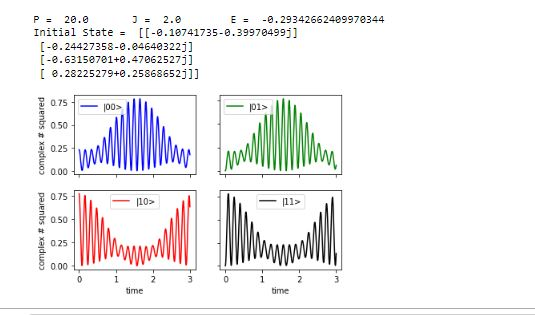

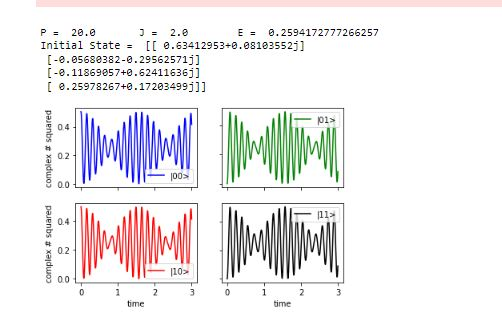

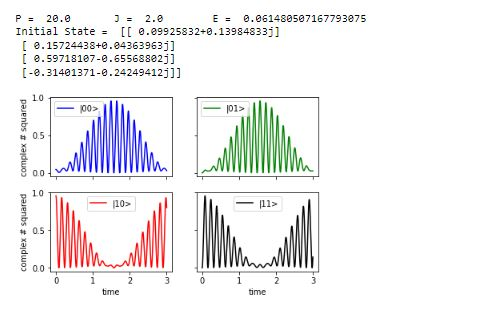

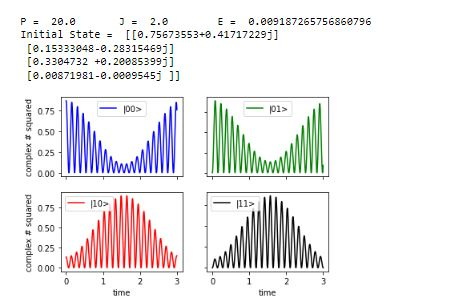

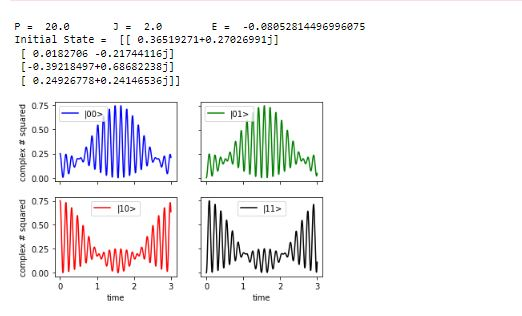

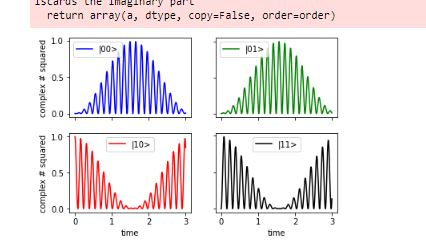

# U[0]psi_initial[0]

D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


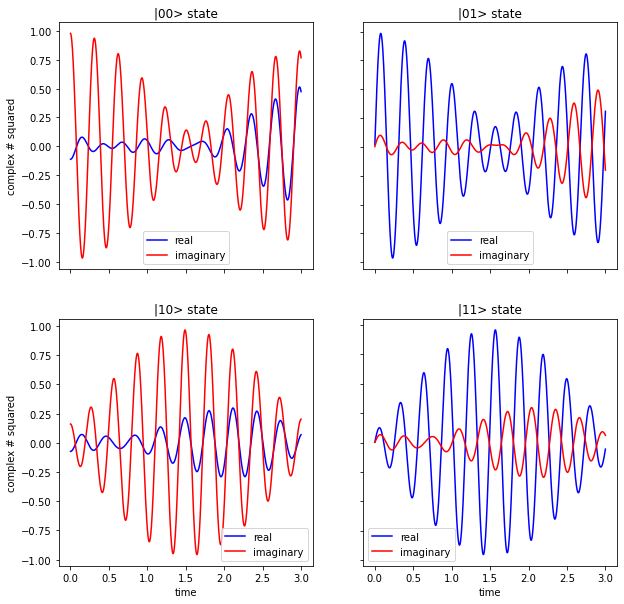

In [512]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].plot(t,a_complex_real[0:nsteps+1],'b',label='real')
axs[0,0].plot(t,a_complex_imag[0:nsteps+1],'r',label='imaginary')
axs[0,0].title.set_text('|00> state')
axs[0,0].legend()
#axs[0,0].set_title('prob distribution of state |00>')
axs[0,1].plot(t,b_complex_real[0:nsteps+1],'b',label='real')
axs[0,1].plot(t,b_complex_imag[0:nsteps+1],'r',label='imaginary')
axs[0,1].title.set_text('|01> state')
axs[0,1].legend()
axs[1,0].plot(t,c_complex_real[0:nsteps+1],'b',label='real')
axs[1,0].plot(t,c_complex_imag[0:nsteps+1],'r',label='imaginary')
axs[1,0].title.set_text('|10> state')
axs[1,0].legend()
axs[1,1].plot(t,d_complex_real[0:nsteps+1],'b',label='real')
axs[1,1].plot(t,d_complex_imag[0:nsteps+1],'r',label='imaginary')
axs[1,1].title.set_text('|11> state')
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='real and imaginary part')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
# print('\nP = ', P, '\tJ = ', J, '\tE = ', E_array[0],'\nInitial State = ',
#      psi_initial[0])

# evolution of second initial state U[0]psi_initial[1]

D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\User\Rojar\Documents\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


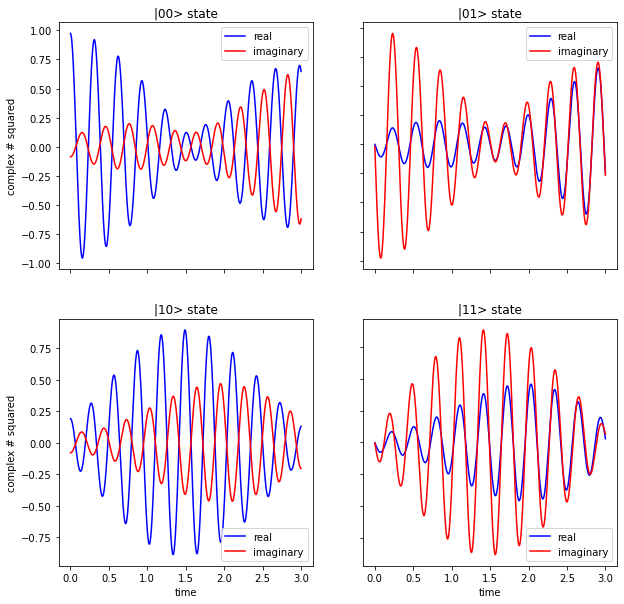

In [513]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].plot(t,a_complex_real[nsteps+1:],'b',label='real')
axs[0,0].plot(t,a_complex_imag[nsteps+1:],'r',label='imaginary')
axs[0,0].title.set_text('|00> state')
axs[0,0].legend()
#axs[0,0].set_title('prob distribution of state |00>')
axs[0,1].plot(t,b_complex_real[nsteps+1:],'b',label='real')
axs[0,1].plot(t,b_complex_imag[nsteps+1:],'r',label='imaginary')
axs[0,1].title.set_text('|01> state')
axs[0,1].legend()
axs[1,0].plot(t,c_complex_real[nsteps+1:],'b',label='real')
axs[1,0].plot(t,c_complex_imag[nsteps+1:],'r',label='imaginary')
axs[1,0].title.set_text('|10> state')
axs[1,0].legend()
axs[1,1].plot(t,d_complex_real[nsteps+1:],'b',label='real')
axs[1,1].plot(t,d_complex_imag[nsteps+1:],'r',label='imaginary')
axs[1,1].title.set_text('|11> state')
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='real and imaginary part')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
# print('\nP = ', P, '\tJ = ', J, '\tE = ', E_array[0],'\nInitial State = ',
#      psi_initial[0])

In [370]:
div = int(len(a_array)/n)
#div, len(a_array), 
a_array[nsteps+1:], len(a_array),a_array[0:nsteps+1], div

(array([0.93358474+0.15798548j, 0.93339206+0.15795624j,
        0.93281412+0.15786843j, ..., 0.58591403+0.67279509j,
        0.58237427+0.66801751j, 0.57859134+0.66296582j]),
 6002,
 array([-0.54102499-0.5765875j , -0.54092843-0.57646832j,
        -0.54063885-0.57611076j, ..., -0.01534838-0.72014082j,
        -0.01373009-0.71413313j, -0.01213026-0.70784574j]),
 3001)

In [335]:
a_array[0:div]

array([0.55402933+0.20104149j, 0.55392068+0.20101731j,
       0.55359478+0.20094479j, ..., 0.52591661-0.06103745j,
       0.52090089-0.06243964j, 0.51569048-0.06378961j])

In [339]:
a_array = np.zeros(len(t),dtype=np.complex128)
b_array = np.zeros(len(t),dtype=np.complex128)
c_array = np.zeros(len(t),dtype=np.complex128)
d_array = np.zeros(len(t),dtype=np.complex128)
for i in range(len(t)):
    a_array[i] = psi_initial[1][0][0]
    b_array[i] = np.abs(psi_initial[1][1][0])**2
    c_array[i] = np.abs(psi_initial[1][2][0])**2
    d_array[i] = np.abs(psi_initial[1][3][0])**2
    psi_initial[1] = U[1] @ psi_initial[1] # U[0] with E[0] value
print(len(a_array))

3001


In [348]:
U[0]@psi_initial[1]

array([[-0.21877075+0.21011731j],
       [ 0.12399501-0.02361054j],
       [-0.84746683-0.18071739j],
       [-0.123241  +0.35497987j]])

In [277]:
len(t), t, T,psi_out

(8,
 array([0.        , 0.42857143, 0.85714286, 1.28571429, 1.71428571,
        2.14285714, 2.57142857, 3.        ]),
 3,
 [array([[-0.32784208+0.6344599j ],
         [ 0.13441474+0.10573863j],
         [ 0.63825281-0.15162829j],
         [-0.08251868-0.15350935j]]),
  array([[-0.19041925+0.6882618j ],
         [ 0.15247129+0.07530493j],
         [ 0.59390473-0.27991511j],
         [-0.11208029-0.13221417j]]),
  array([[ 0.41312858-0.48613839j],
         [-0.13249523-0.1096638j ],
         [-0.43562662+0.57895841j],
         [ 0.1544231 +0.1208438j ]]),
  array([[ 0.30464531-0.56086073j],
         [-0.15158487-0.07938395j],
         [-0.30744613+0.65635251j],
         [ 0.17514485+0.08572765j]])])

In [265]:
#U
a_array, t

(array([0.64941092+0.j, 0.3247123 +0.j, 0.56032702+0.j, 0.        +0.j]),
 array([0. , 1.5, 3. ]))

In [236]:
phi_initial,psi_initial

({0: array([[ 0.23097945+0.07742336j],
         [-0.29467329+0.45091088j]]),
  1: array([[0.08193697-0.46236024j],
         [0.31106388+0.21248491j]])},
 {0: array([[ 0.39070635+0.13096316j],
         [ 0.        +0.j        ],
         [-0.49844575+0.76272474j],
         [-0.        +0.j        ]]),
  1: array([[0.13610845-0.76804319j],
         [0.        +0.j        ],
         [0.51671938+0.35296632j],
         [0.        +0.j        ]])})

In [234]:
Hamil

{0: array([[ 0.        +0.j, 20.        +0.j,  0.        +0.j,
          0.        +0.j],
        [20.        +0.j,  0.49046473+0.j,  2.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  2.        +0.j,  0.        +0.j,
         20.        +0.j],
        [ 0.        +0.j,  0.        +0.j, 20.        +0.j,
          0.49046473+0.j]]),
 1: array([[ 0.        +0.j, 20.        +0.j,  0.        +0.j,
          0.        +0.j],
        [20.        +0.j, -0.38279072+0.j,  2.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  2.        +0.j,  0.        +0.j,
         20.        +0.j],
        [ 0.        +0.j,  0.        +0.j, 20.        +0.j,
         -0.38279072+0.j]])}

TypeError: imshow() got multiple values for argument 'cmap'

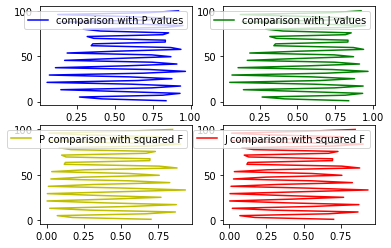

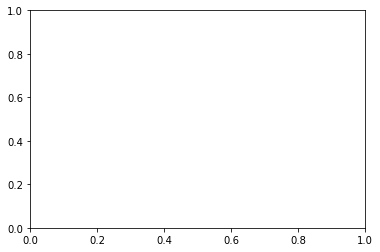

In [338]:
E11,E01,P11, E_11, E_01, J11 = sp.symbols("E_{11} E_{01} P_{1} E_{11c} E_{01c} J_{11}")
Hcopy = H
E0 = 1 #variance of uniform distrib of energies E0 
#-> e11 derived here ->random

###################################################################################################################################

E11 = float(-E0/2 +(np.random.rand(1)*E0))
P11_array = np.linspace(1, 100, 50) / E0 #can reduce to 6?
J_array = np.linspace(1, 100, 50) / E0
list1={}
for i in range(len(P11_array)):
    list1["H_{0}".format(i)] = np.array(Hcopy.subs({"E_{11}":E11,"P_{1}":P11_array[i], "J_{11}":J_array[i]})).astype('complex128') * 1/E0
#output_example = list1["H_2"]

#also a random arrangement of P and J values combo 

#for i in range(len(P11_array)):
#    list1["H_{0}".format(i)] = np.array(Hcopy.subs({"E_{11}":E11,"P_{1}":rand_num_array(P11_array), "J_{11}":rand_num_array(J_array)})).astype('complex128') * 1/E0

###################################################################################################################################

hbar = 1
t = 3 * E0/hbar #simulation time -> scaled time
list2 = {}
for i in range(len(P11_array)):
    list2["U_{0}".format(i)] = expm(-1j* list1["H_{0}".format(i)] * t)
#output_example = list2["U_2"]

###################################################################################################################################

#now need a random set of psi_intial states, where psi_initial = comp (x) Vacuum state
#that is, psi_intial = z1|00> + z2|10> * 1/sqrt(|z1|^2+|z2|^2), z1 = x+iy
x1 = random.random()
y1 = random.random()
x2 = random.random()
y2 = random.random()
z1 = complex(x1,y1)
z2 = complex(x2,y2)
psi_initial = 1/np.sqrt(np.abs(z1)**2+np.abs(z2)**2)*(z1*MTP(gnd_state,gnd_state) + z2*MTP(exc_state,gnd_state)) 

list3={}
for i in range(len(P11_array)):
    list3["psi_{0}".format(i)] = list2["U_{0}".format(i)]@psi_initial #where t = 3 units
    
###################################################################################################################################

# now lets try calculate pho for each final state psi that corresponds
# to each U operator that itself corresponds to each 
# P and J values
list4 = {}
for i in range(len(P11_array)):
    list4["pho_{0}".format(i)] = MTP(list3["psi_{0}".format(i)],list3["psi_{0}".format(i)].T) 

###################################################################################################################################

# now partial trace of this, where subsystem A = computational site = c
# and subsystem B = resercoir site = r 
pho_c = {}
Id = np.eye(2)
for i in range(len(P11_array)):
    pho_c["pho_c_{0}".format(i)] = MTP(Id, gnd_state.T)@list4['pho_{0}'.format(i)]@MTP(Id, gnd_state) + MTP(Id, exc_state.T)@list4['pho_{0}'.format(i)]@MTP(Id, exc_state)

###################################################################################################################################

# now lets calcualte the fidelity, where |phi_ideal> = X|psi_qubit>
# and fidelity F = <phi_ideal|pho_c|phi_ideal>

X_gate = np.array([[0,1],[1,0]])
psi_qubit = (gnd_state + exc_state) * 1/np.sqrt(2)
phi_ideal = X_gate@psi_qubit

F = {}
for i in range(len(P11_array)):
    F["F_{0}".format(i)] = phi_ideal.T @ pho_c["pho_c_{0}".format(i)] @ phi_ideal

###################################################################################################################################

# lets make 2D plots first, comparing F to J, F to P 

F_array = np.zeros(len(P11_array))
for i in range(len(P11_array)):
    F_array[i] = rand_num_array(abs(list(F.values())[i][0]))

fig, axs = plt.subplots(2,2)
axs[0,0].plot(F_array, P11_array, 'b', label = 'comparison with P values')
axs[0,0].legend()
#axs[0,0].set_title('prob distribution of state |00>')
axs[0,1].plot(F_array, J_array, 'g', label = 'comparison with J values')
axs[0,1].legend()
axs[1,0].plot(F_array**2, P11_array, 'y', label = 'P comparison with squared F')
axs[1,0].legend()
axs[1,1].plot(F_array**2, J_array, 'r', label = 'J comparison with squared F')
axs[1,1].legend()

# for ax in axs.flat:
#     ax.set(xlabel='time', ylabel='complex # squared')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()


###################################################################################################################################   

#lets try create  a mesh grid, a color map of the 2D space


fig, ax = plt.subplots()
X,Y = np.meshgrid(P11_array,J_array)
#ax.set_aspect('auto')
plt.imshow(X,Y,F_array, cmap='viridis', interpolation='bicubic')
plt.show()

###################################################################################################################################
# plt.plot(t, np.abs(a)**2, 'b', label = '|00>')
# plt.plot(t, np.abs(b)**2, 'g', label = '|01>')
# #plt.xlim(1.4,1.8) # to see if it goes zero
# # plt.plot(t, np.abs(c)**2, 'y', label = '|10>')
# # plt.plot(t, np.abs(d)**2, 'k', label = '|11>')
# plt.legend()
#plt.savefig('1_1withintialstate_00_compare.jpg')

# ideal operation/states